In [1]:
import pandas as pd
import numpy as np
import joblib

In [3]:
data = pd.read_csv('health_data.csv')

In [5]:
data.head()

,age,gender,height,weight,bmi,gad7_score,self_reported_stress,physical_activity_per_week,primary_goal,workout_goal_days,importance_stress_reduction,segment_label
0,56,Male,1.77,63.2,20.2,15,6,0,imporve fitness,1,1,HighAnx_LowAct
1,46,Female,1.68,100.8,35.7,2,9,5,increase mindfulness,1,2,PhysRisk
2,32,Female,1.61,64.0,24.7,21,10,0,lose weight,4,5,HighAnx_LowAct
3,60,Female,1.90,104.2,28.9,8,4,0,lose weight,7,3,Inactive
4,25,Male,1.67,94.0,33.7,14,7,7,reduce stress,3,4,PhysRisk


In [7]:
data['segment_label'].unique()

array(['HighAnx_LowAct', 'PhysRisk', 'Inactive', 'LowAnx_HighAct',
       'Wellness seeker', 'ModAnx_ModAct'], dtype=object)

In [9]:
#encoding the targets to specific values
data['segment_label'] = data['segment_label'].map(
    {'HighAnx_LowAct':0,
     'ModAnx_ModAct':1,
     'LowAnx_HighAct':2,
     'PhysRisk':3,
     'Wellness seeker':4,
     'Inactive':5,
    }

)

data['gender'] = data['gender'].map(
    {'Male':0,
     'Female':1,
    }
)

In [11]:
data['primary_goal'] = data['primary_goal'].map(
    {'imporve fitness':0,
     'increase mindfulness':1,
     'lose weight':2,
     'reduce stress':3
    }
)

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV, 
    cross_val_score, validation_curve, learning_curve
)
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_curve, roc_curve, auc, f1_score,
    precision_score, recall_score
)
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

In [15]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [17]:
#defining train-test split
X = data.drop(columns=['segment_label'])
y = data['segment_label']
X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.2,random_state=42
)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [21]:
#Baseline model evaluation
baseline_rf = RandomForestClassifier(n_estimators=100, random_state=42)
baseline_rf.fit(X_train, y_train)
baseline_pred = baseline_rf.predict(X_test)
baseline_accuracy = accuracy_score(y_test, baseline_pred)

In [23]:
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")

Baseline Accuracy: 0.9450


In [25]:
#all parameters to check for model performance
param_grid_comprehensive = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None, 0.5, 0.7],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

In [29]:
print("Parameter grid defined with the following hyperparameters:")
for param, values in param_grid_comprehensive.items():
    print(f"  {param}: {values}")

Parameter grid defined with the following hyperparameters:
  n_estimators: [50, 100, 200, 300, 500]
  max_depth: [None, 5, 10, 15, 20, 25]
  min_samples_split: [2, 5, 10, 15]
  min_samples_leaf: [1, 2, 4, 8]
  max_features: ['sqrt', 'log2', None, 0.5, 0.7]
  bootstrap: [True, False]
  criterion: ['gini', 'entropy']
  class_weight: [None, 'balanced', 'balanced_subsample']


In [31]:
#randomized search

In [33]:
rf_random = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf_random,
    param_distributions=param_grid_comprehensive,
    n_iter=100,  # Number of parameter combinations to try
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [35]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 5, 10, 15, 20, 25],
                                        'max_features': ['sqrt', 'log2', None,
                                                         0.5, 0.7],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [50, 100, 200, 300,
                                                         500]},
                   random_state=42, scoring='accuracy', verbose=1)

In [36]:
print(f"Best Random Search Score: {random_search.best_score_:.4f}")
print(f"Best Random Search Parameters: {random_search.best_params_}")

Best Random Search Score: 0.9350
Best Random Search Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.7, 'max_depth': 5, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': False}


In [39]:
#using best parameter search to create refined grid:
best_params = random_search.best_params_
refined_grid = {
    'n_estimators': [best_params['n_estimators'] - 50, 
                     best_params['n_estimators'], 
                     best_params['n_estimators'] + 50],
    'max_depth': [best_params['max_depth']],
    'min_samples_split': [max(2, best_params['min_samples_split'] - 2),
                          best_params['min_samples_split'],
                          best_params['min_samples_split'] + 2],
    'min_samples_leaf': [max(1, best_params['min_samples_leaf'] - 1),
                         best_params['min_samples_leaf'],
                         best_params['min_samples_leaf'] + 1],
    'max_features': [best_params['max_features']],
    'bootstrap': [best_params['bootstrap']]
}

In [41]:
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=refined_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [43]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [5],
                         'max_features': [0.7], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': [250, 300, 350]},
             scoring='accuracy', verbose=1)

In [45]:
print(f"Best Grid Search Score: {grid_search.best_score_:.4f}")
print(f"Best Grid Search Parameters: {grid_search.best_params_}")

Best Grid Search Score: 0.9338
Best Grid Search Parameters: {'bootstrap': False, 'max_depth': 5, 'max_features': 0.7, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 250}


In [47]:
#multi scoring metrics evaluation

In [49]:
scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
best_rf = grid_search.best_estimator_

cv_scores = {}
for metric in scoring_metrics:
    scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring=metric)
    cv_scores[metric] = scores
    print(f"{metric.upper()}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

ACCURACY: 0.9338 (+/- 0.0127)
PRECISION_WEIGHTED: 0.9455 (+/- 0.0113)
RECALL_WEIGHTED: 0.9338 (+/- 0.0127)
F1_WEIGHTED: 0.9267 (+/- 0.0163)


In [51]:
def plot_validation_curves(X_train, y_train):
    """Plot validation curves for key hyperparameters"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # n_estimators validation curve
    param_range = [10, 50, 100, 200, 300, 500]
    train_scores, val_scores = validation_curve(
        RandomForestClassifier(random_state=42), X_train, y_train,
        param_name='n_estimators', param_range=param_range,
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    axes[0, 0].plot(param_range, np.mean(train_scores, axis=1), 'o-', label='Training')
    axes[0, 0].plot(param_range, np.mean(val_scores, axis=1), 'o-', label='Validation')
    axes[0, 0].set_xlabel('n_estimators')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Validation Curve - n_estimators')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # max_depth validation curve
    param_range = [5, 10, 15, 20, 25, None]
    # Handle None value for max_depth
    param_range_numeric = [5, 10, 15, 20, 25, 50]  # Use 50 as proxy for None
    train_scores, val_scores = validation_curve(
        RandomForestClassifier(random_state=42), X_train, y_train,
        param_name='max_depth', param_range=[5, 10, 15, 20, 25],
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    axes[0, 1].plot([5, 10, 15, 20, 25], np.mean(train_scores, axis=1), 'o-', label='Training')
    axes[0, 1].plot([5, 10, 15, 20, 25], np.mean(val_scores, axis=1), 'o-', label='Validation')
    axes[0, 1].set_xlabel('max_depth')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Validation Curve - max_depth')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # min_samples_split validation curve
    param_range = [2, 5, 10, 15, 20]
    train_scores, val_scores = validation_curve(
        RandomForestClassifier(random_state=42), X_train, y_train,
        param_name='min_samples_split', param_range=param_range,
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    axes[1, 0].plot(param_range, np.mean(train_scores, axis=1), 'o-', label='Training')
    axes[1, 0].plot(param_range, np.mean(val_scores, axis=1), 'o-', label='Validation')
    axes[1, 0].set_xlabel('min_samples_split')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title('Validation Curve - min_samples_split')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # min_samples_leaf validation curve
    param_range = [1, 2, 4, 8, 16]
    train_scores, val_scores = validation_curve(
        RandomForestClassifier(random_state=42), X_train, y_train,
        param_name='min_samples_leaf', param_range=param_range,
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    axes[1, 1].plot(param_range, np.mean(train_scores, axis=1), 'o-', label='Training')
    axes[1, 1].plot(param_range, np.mean(val_scores, axis=1), 'o-', label='Validation')
    axes[1, 1].set_xlabel('min_samples_leaf')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].set_title('Validation Curve - min_samples_leaf')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [53]:
def plot_learning_curves(best_estimator, X_train, y_train):
    """Plot learning curves to check for overfitting"""
    train_sizes, train_scores, val_scores = learning_curve(
        best_estimator, X_train, y_train, cv=5,
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1, random_state=42
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation Score')
    plt.fill_between(train_sizes, 
                     np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1),
                     alpha=0.1)
    plt.fill_between(train_sizes, 
                     np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                     np.mean(val_scores, axis=1) + np.std(val_scores, axis=1),
                     alpha=0.1)
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy Score')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

In [55]:

def comprehensive_model_evaluation(model, X_test, y_test):
    """Comprehensive evaluation of the final model"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Final Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Confusion Matrix
    plt.figure(figsize=(15, 12))
    
    plt.subplot(2, 3, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Classification Report Heatmap
    plt.subplot(2, 3, 2)
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).iloc[:-1, :].T
    sns.heatmap(report_df.iloc[:, :-1], annot=True, cmap='viridis')
    plt.title('Classification Report')
    
    # Feature Importance
    plt.subplot(2, 3, 3)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:15]
        plt.bar(range(len(indices)), importances[indices])
        plt.title('Top 15 Feature Importances')
        plt.xlabel('Feature Index')
        plt.ylabel('Importance')
    
    # ROC Curves (for multiclass)
    plt.subplot(2, 3, 4)
    if len(np.unique(y_test)) > 2:
        # Multiclass ROC
        y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
        n_classes = y_test_bin.shape[1]
        
        for i in range(min(n_classes, 3)):  # Show only first 3 classes
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    else:
        # Binary classification
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    
    # Prediction Confidence Distribution
    plt.subplot(2, 3, 5)
    max_proba = np.max(y_pred_proba, axis=1)
    plt.hist(max_proba, bins=20, alpha=0.7)
    plt.xlabel('Maximum Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Prediction Confidence Distribution')
    
    # Model Complexity vs Performance
    plt.subplot(2, 3, 6)
    complexity_metrics = {
        'n_estimators': model.n_estimators,
        'max_depth': model.max_depth if model.max_depth else 25,
        'min_samples_split': model.min_samples_split,
        'min_samples_leaf': model.min_samples_leaf
    }
    
    plt.bar(complexity_metrics.keys(), complexity_metrics.values())
    plt.title('Model Complexity Parameters')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [61]:
def plot_hyperparameter_comparison(search_results, title):
    """Plot comparison of different hyperparameter combinations"""
    results_df = pd.DataFrame(search_results.cv_results_)
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Score distribution
    plt.subplot(2, 3, 1)
    plt.hist(results_df['mean_test_score'], bins=30, alpha=0.7)
    plt.xlabel('Cross-validation Score')
    plt.ylabel('Frequency')
    plt.title(f'{title} - Score Distribution')
    
    # Plot 2: Top 10 parameter combinations
    plt.subplot(2, 3, 2)
    top_10 = results_df.nlargest(10, 'mean_test_score')
    plt.barh(range(len(top_10)), top_10['mean_test_score'])
    plt.xlabel('Cross-validation Score')
    plt.ylabel('Parameter Combination Rank')
    plt.title('Top 10 Parameter Combinations')
    
    # Plot 3: Parameter importance (for key parameters)
    if 'param_n_estimators' in results_df.columns:
        plt.subplot(2, 3, 3)
        param_scores = results_df.groupby('param_n_estimators')['mean_test_score'].mean()
        param_scores.plot(kind='bar')
        plt.xlabel('n_estimators')
        plt.ylabel('Mean CV Score')
        plt.title('n_estimators vs Performance')
        plt.xticks(rotation=45)
    
    # Plot 4: Score vs training time
    plt.subplot(2, 3, 4)
    plt.scatter(results_df['mean_fit_time'], results_df['mean_test_score'], alpha=0.6)
    plt.xlabel('Mean Fit Time (seconds)')
    plt.ylabel('Cross-validation Score')
    plt.title('Performance vs Training Time')
    
    # Plot 5: Feature importance of best model
    plt.subplot(2, 3, 5)
    if hasattr(search_results.best_estimator_, 'feature_importances_'):
        importances = search_results.best_estimator_.feature_importances_
        indices = np.argsort(importances)[::-1][:10]  # Top 10 features
        plt.bar(range(len(indices)), importances[indices])
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Importance')
        plt.title('Top 10 Feature Importances')
    
    plt.tight_layout()
    plt.show()

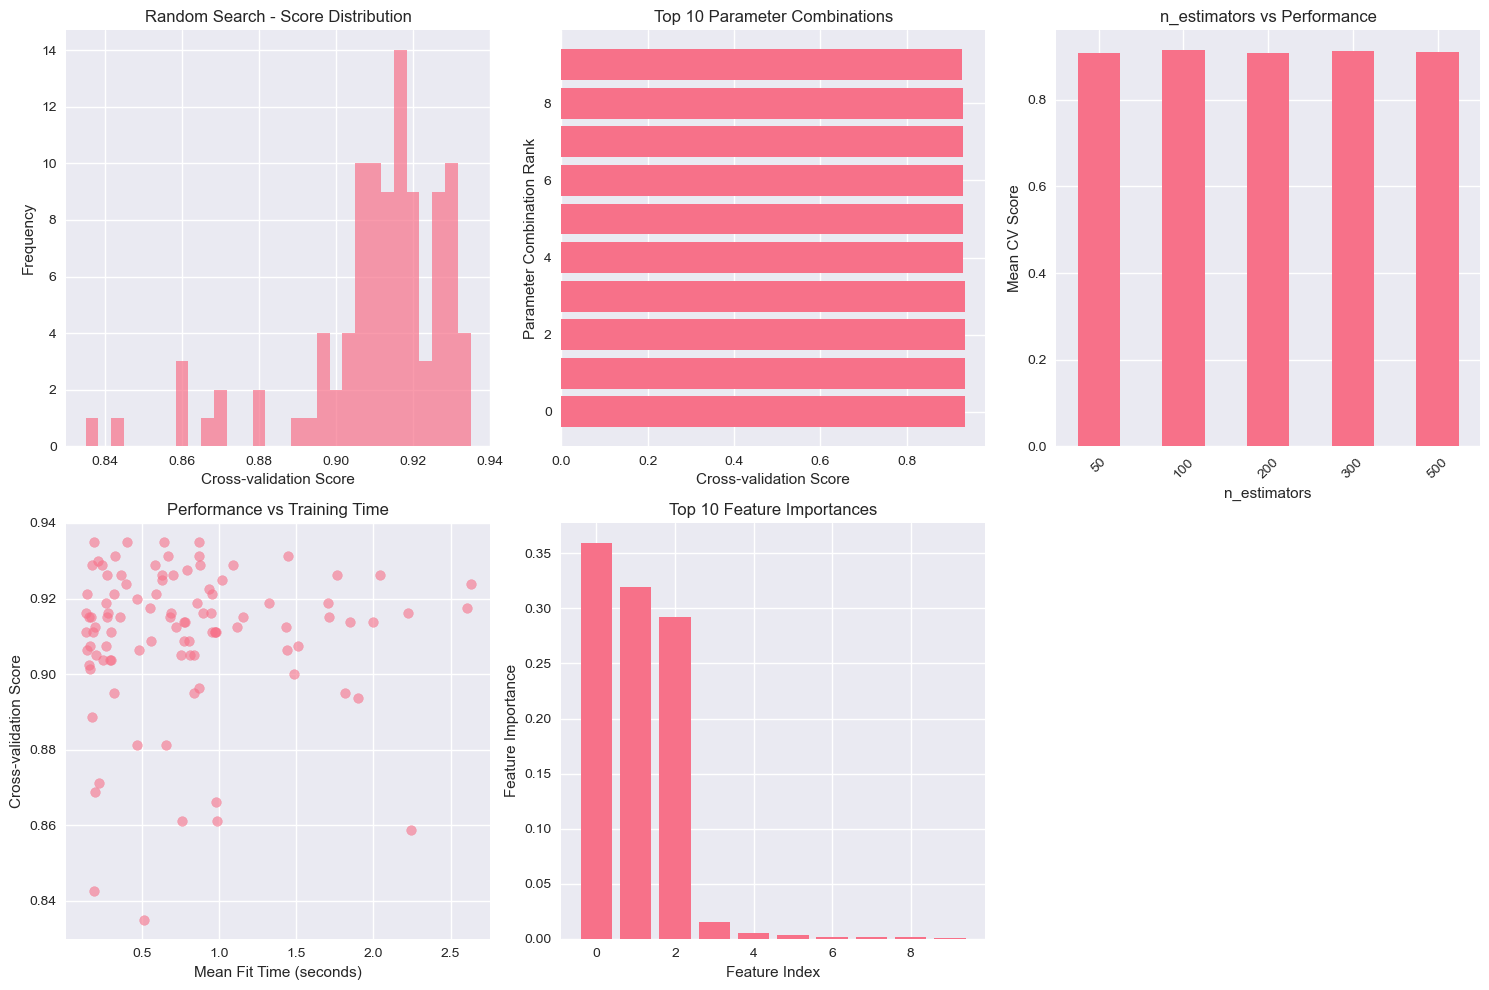

In [63]:
plot_hyperparameter_comparison(random_search, "Random Search")


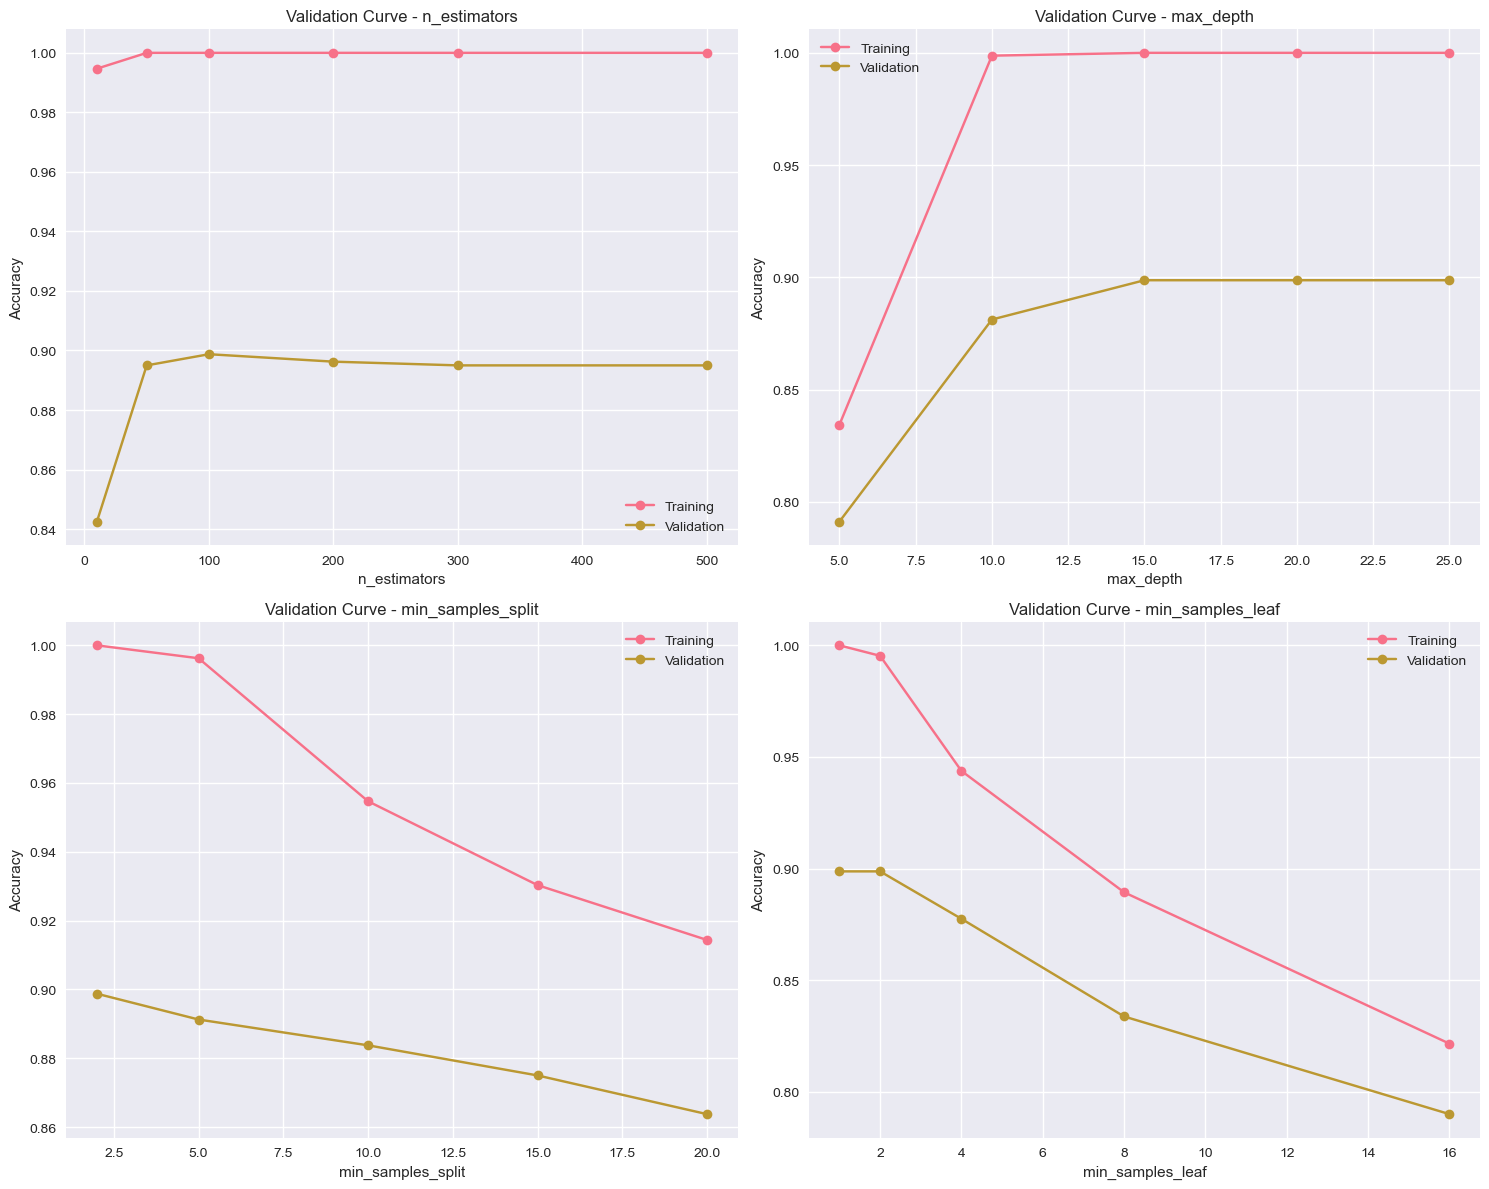

In [65]:
plot_validation_curves(X_train, y_train)

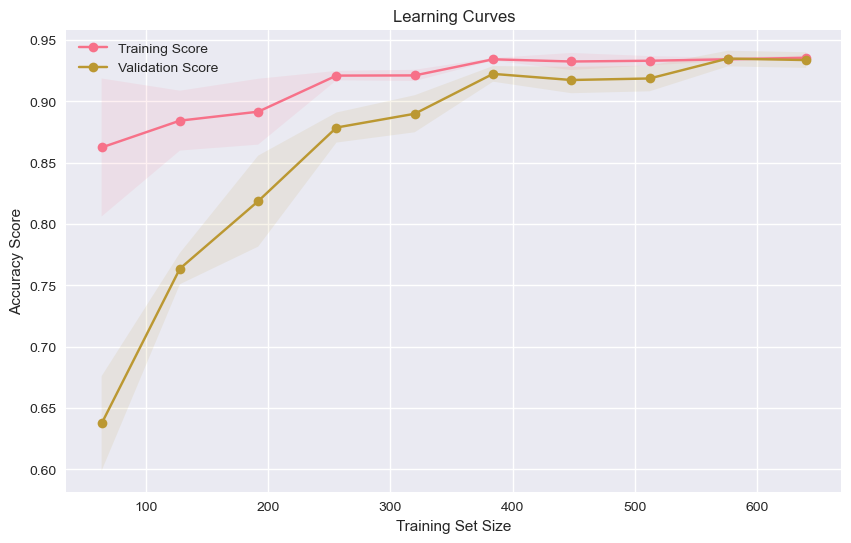

In [68]:
plot_learning_curves(grid_search.best_estimator_, X_train, y_train)

Final Model Performance:
Accuracy: 0.9550
Precision: 0.9615
Recall: 0.9550
F1-Score: 0.9523


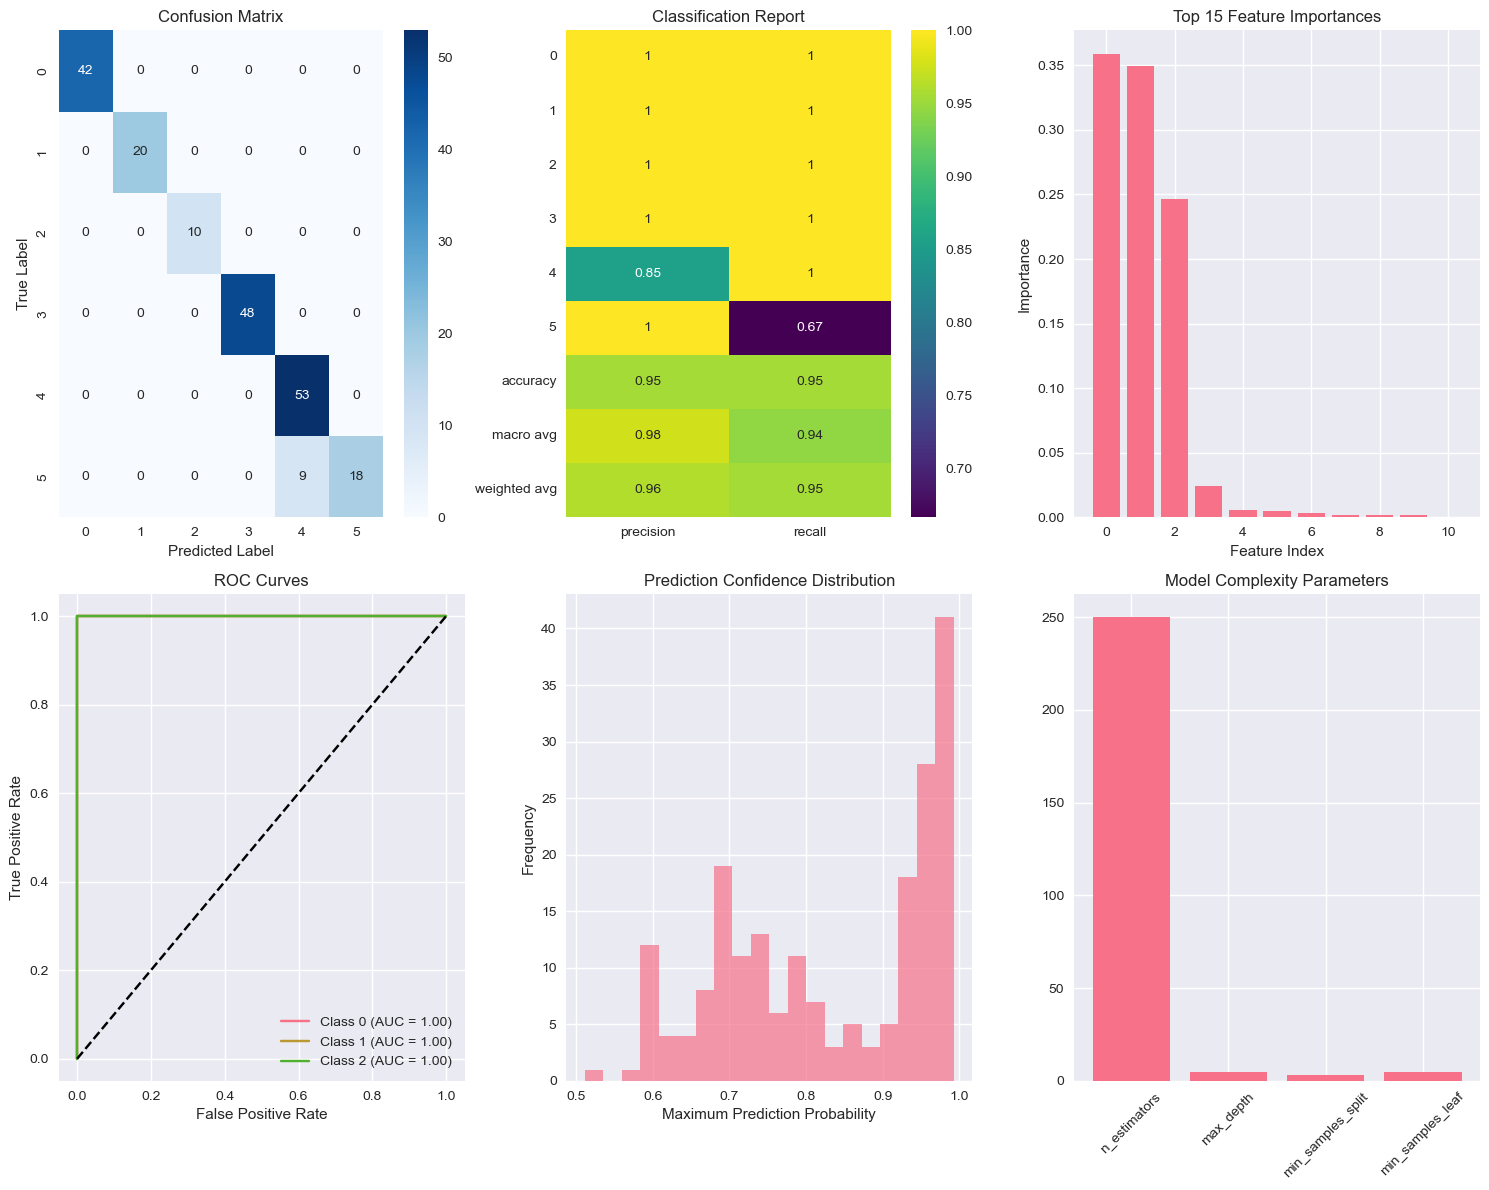

In [69]:
comprehensive_model_evaluation(grid_search.best_estimator_, X_test, y_test)


In [72]:
models_comparison = {
    'Baseline': baseline_accuracy,
    'Random Search Best': random_search.best_score_,
    'Grid Search Best': grid_search.best_score_
}

In [74]:
for model_name, score in models_comparison.items():
    print(f"{model_name}: {score:.4f}")

Baseline: 0.9450
Random Search Best: 0.9350
Grid Search Best: 0.9338


In [76]:
best_model = grid_search.best_estimator_
print(f"\n✅ RECOMMENDED FINAL MODEL:")
print(f"Parameters: {grid_search.best_params_}")
print(f"Cross-validation Score: {grid_search.best_score_:.4f}")


✅ RECOMMENDED FINAL MODEL:
Parameters: {'bootstrap': False, 'max_depth': 5, 'max_features': 0.7, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 250}
Cross-validation Score: 0.9338


In [78]:
final_test_score = best_model.score(X_test, y_test)
print(f"Test Set Accuracy: {final_test_score:.4f}")

Test Set Accuracy: 0.9550


In [80]:
joblib.dump(best_model, 'segment_classifier.pkl')

['segment_classifier.pkl']